In [16]:
import DeconV as dv

import matplotlib.pyplot as plt

import pandas as pd
import scanpy as sc
import torch

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
sc.__version__

'1.9.1'

In [18]:
reference_file = "../../data/pbmc/reference.h5ad"
bulk_file = "../../data/pbmc/bulk.txt"
cell_types = [
    'CD4 T', 'Monocytes',
    'B cells', 'CD8 T',
    'NK', 'Monocytes',
    'DCs']

In [19]:
adata = sc.read_h5ad(reference_file)
adata.X = adata.X.astype("float32").toarray()

dv.tl.scale_log_center(adata)

adata = adata[adata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(adata.obs.groupby("labels").size())
bulk_df = pd.read_table(bulk_file, index_col=0).T
adata.shape

labels
B cells       343
CD4 T        1304
CD8 T         152
DCs            35
Monocytes     635
NK            153
dtype: int64


(2622, 13404)

In [20]:
sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"

In [21]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

/home/lutrarutra/.pyenv/versions/3.10.9/envs/deconv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


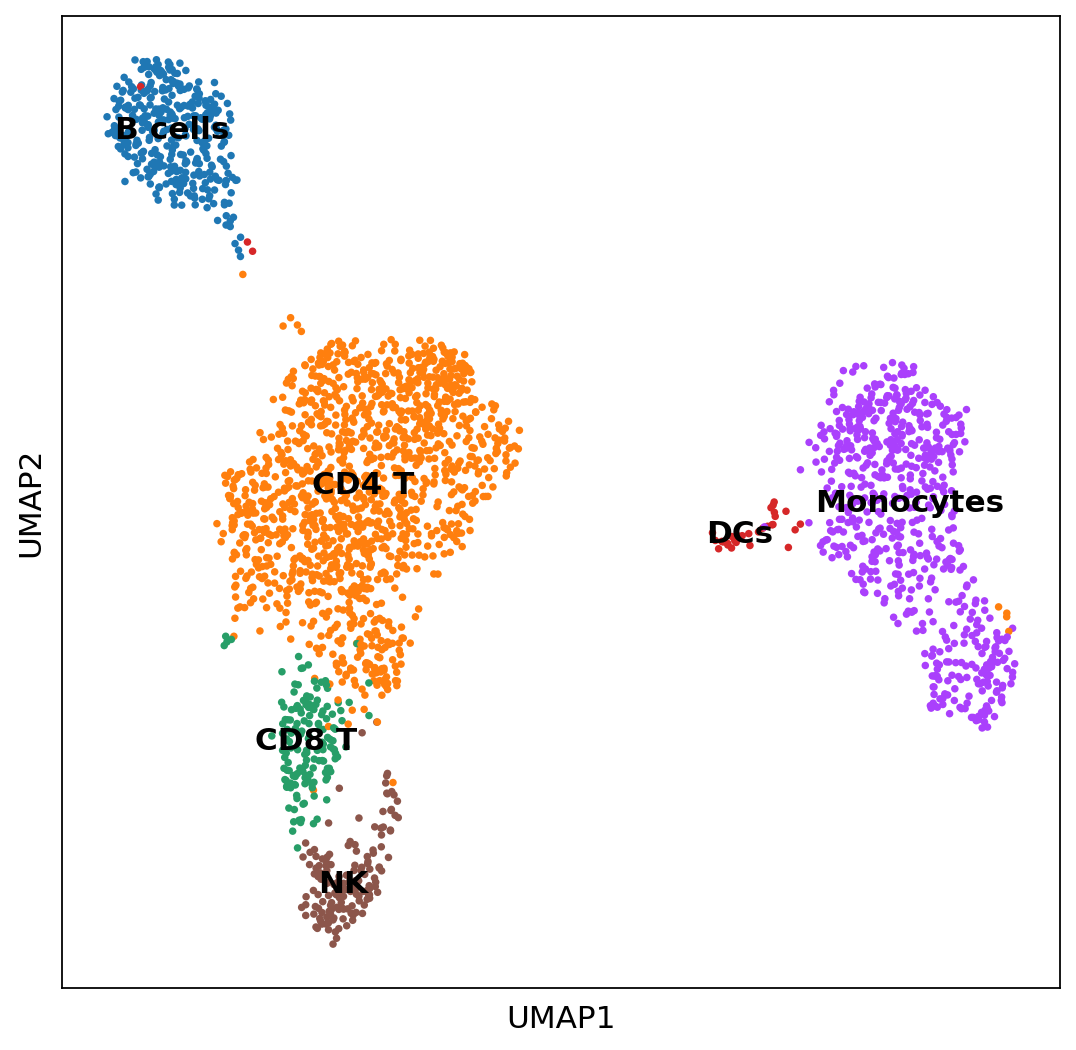

In [22]:
sc.pl.umap(adata, color=["labels"], frameon=True, legend_loc="on data", title="")

## GPU Acceleration

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Define Model and Fit Reference

In [ ]:
decon = dv.DeconV(
    adata,
    bulk=bulk_df,
    cell_type_key="labels",  # cell_type_key is the column key in adata.obs that holds the cell type annotations 
    dropout_type="separate",        # separate, shared, or None
    model_type="nb",             # gamma, beta, nb, lognormal, or static    
    device=device,
    layer="counts",
)

Using 13404 common genes between the reference and the bulk data.


In [25]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999)

100%|██████████| 2000/2000 [02:14<00:00, 14.82it/s, loss=3.05e+03, lr=1.35e-02]


## (Optional): Asses fit of the model

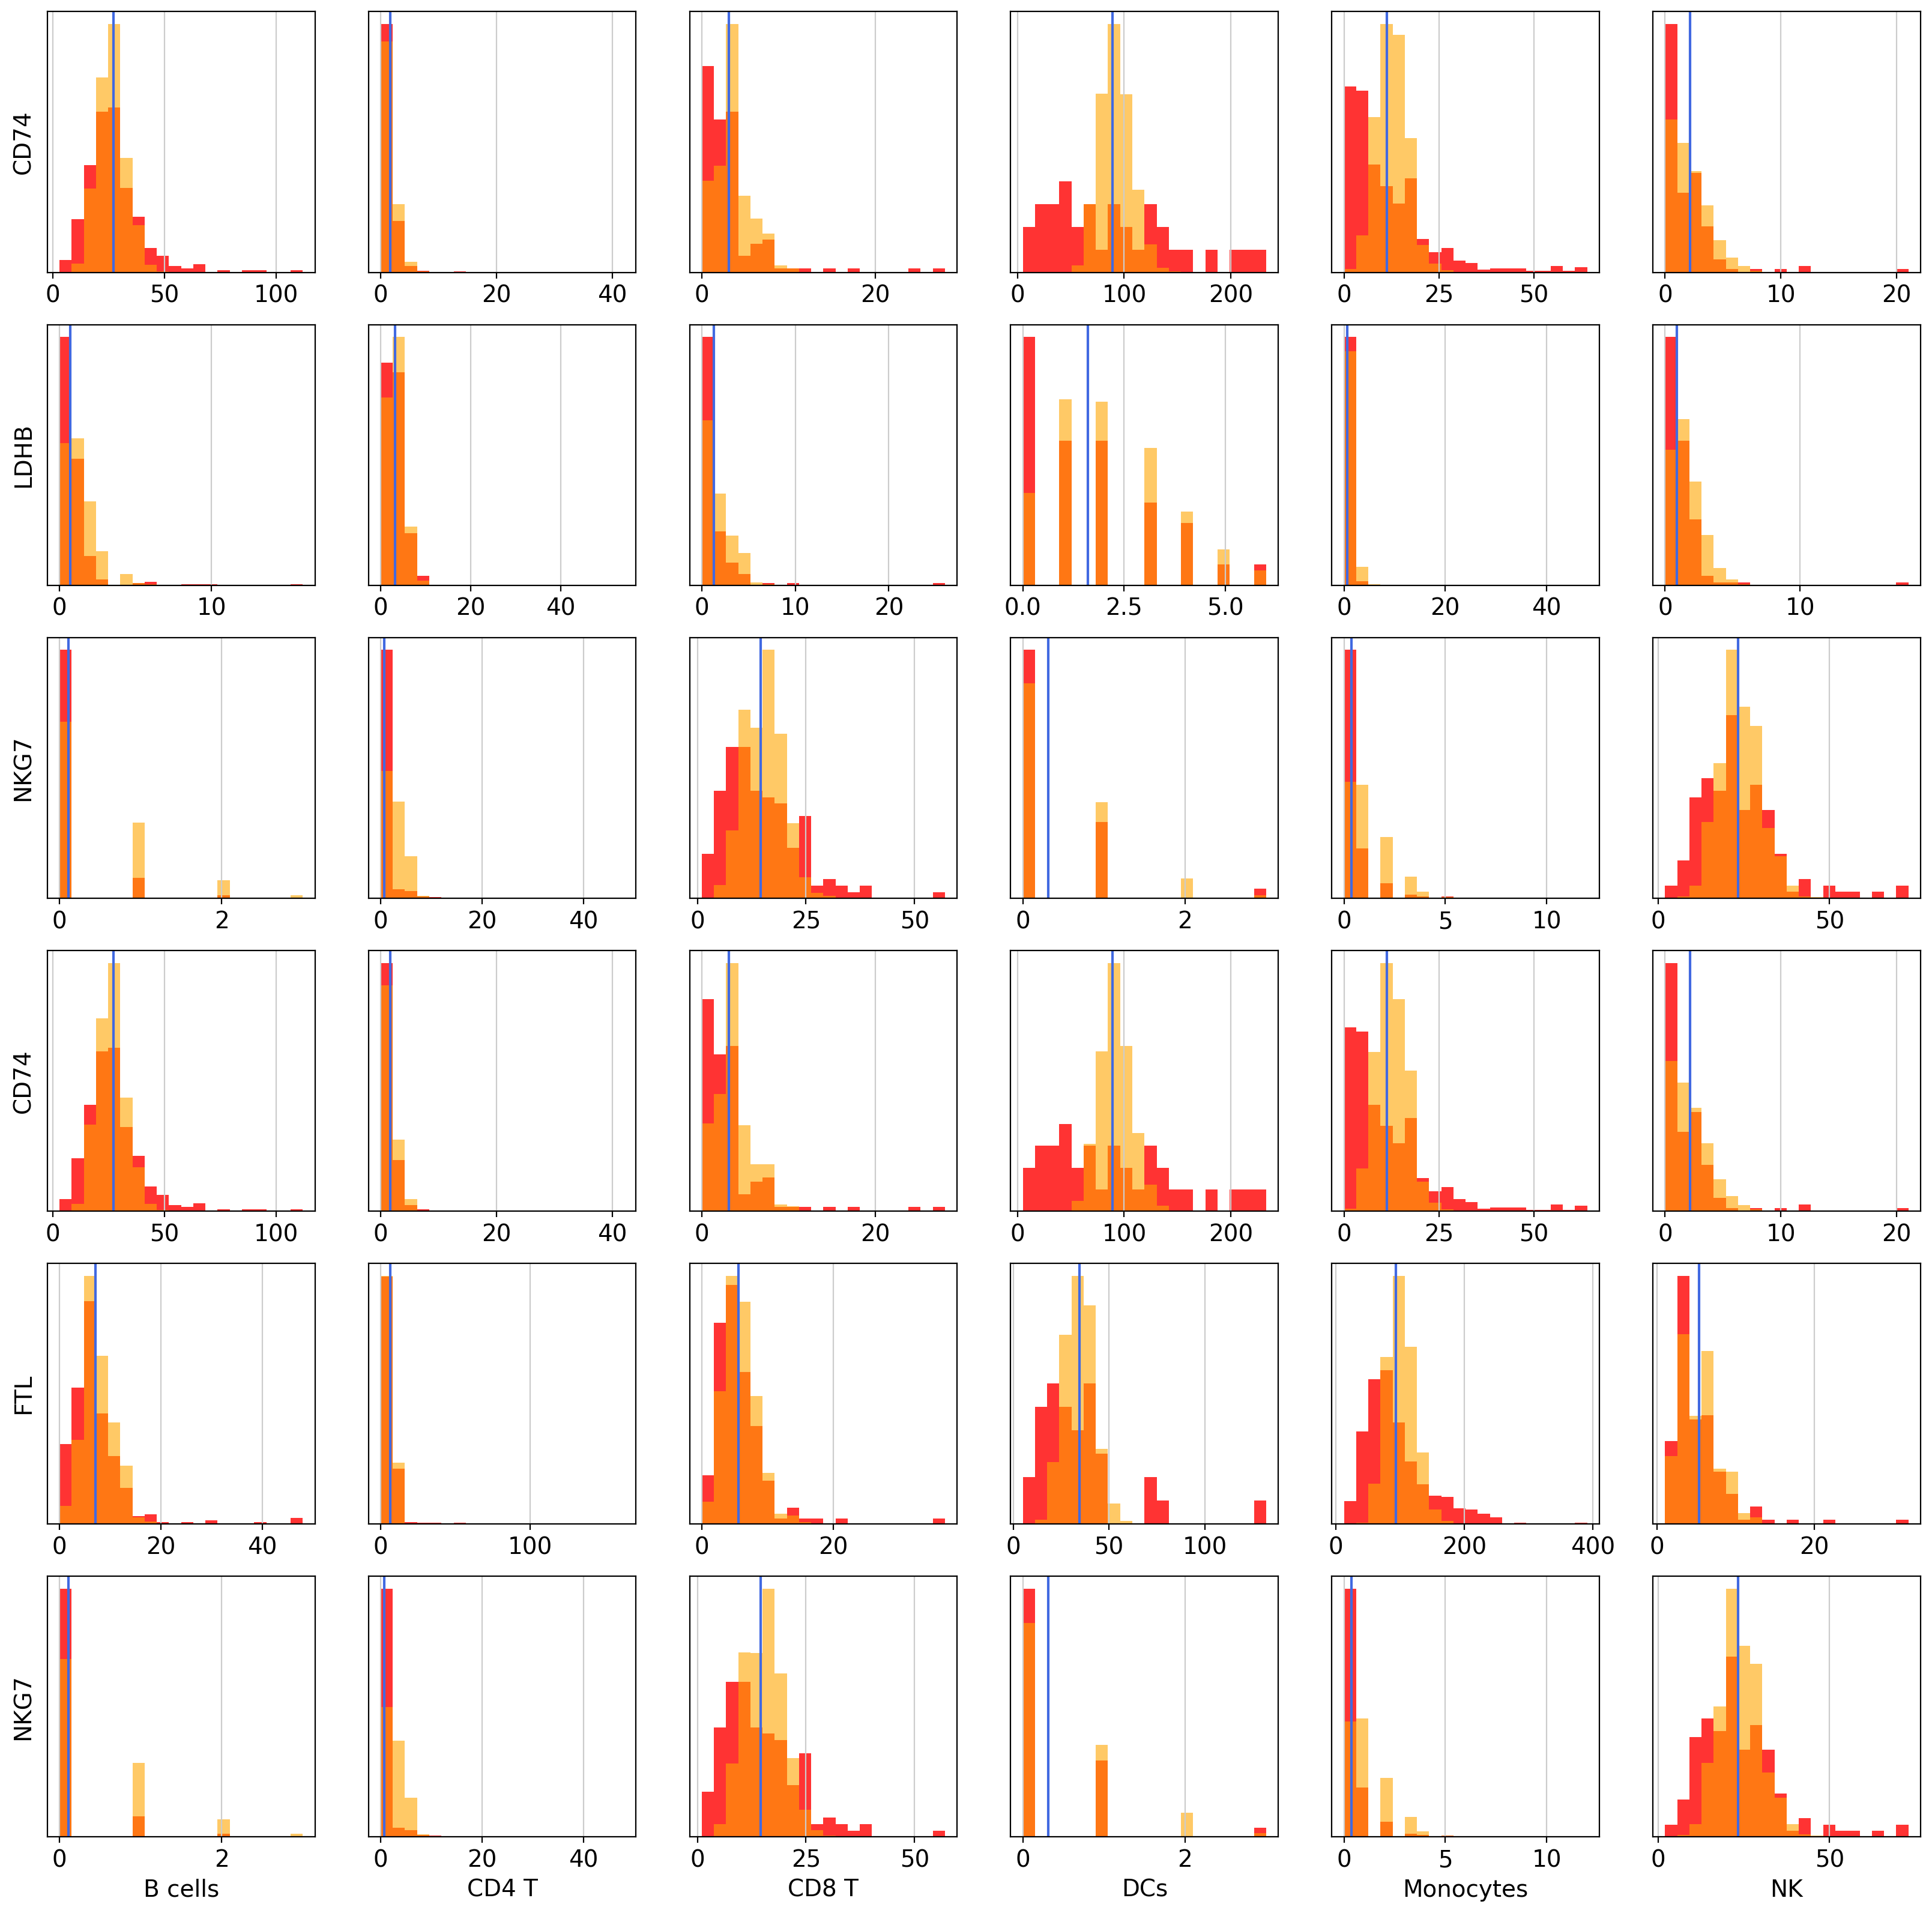

In [26]:
decon.check_fit()

## Deconvolute

In [27]:
proportions = decon.deconvolute(model_dropout=True, lrd=0.999, lr=0.1, num_epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s, loss=5.56e+11, lr=9.99e-02]

100%|██████████| 1000/1000 [00:05<00:00, 168.64it/s, loss=5.17e+07, lr=3.68e-02]


## Comparison to Ground Truth

In [28]:
true_df = pd.read_csv("../../data/pbmc/true.csv", sep=",", index_col=0)
true_df = true_df.reindex(sorted(true_df.columns), axis=1)

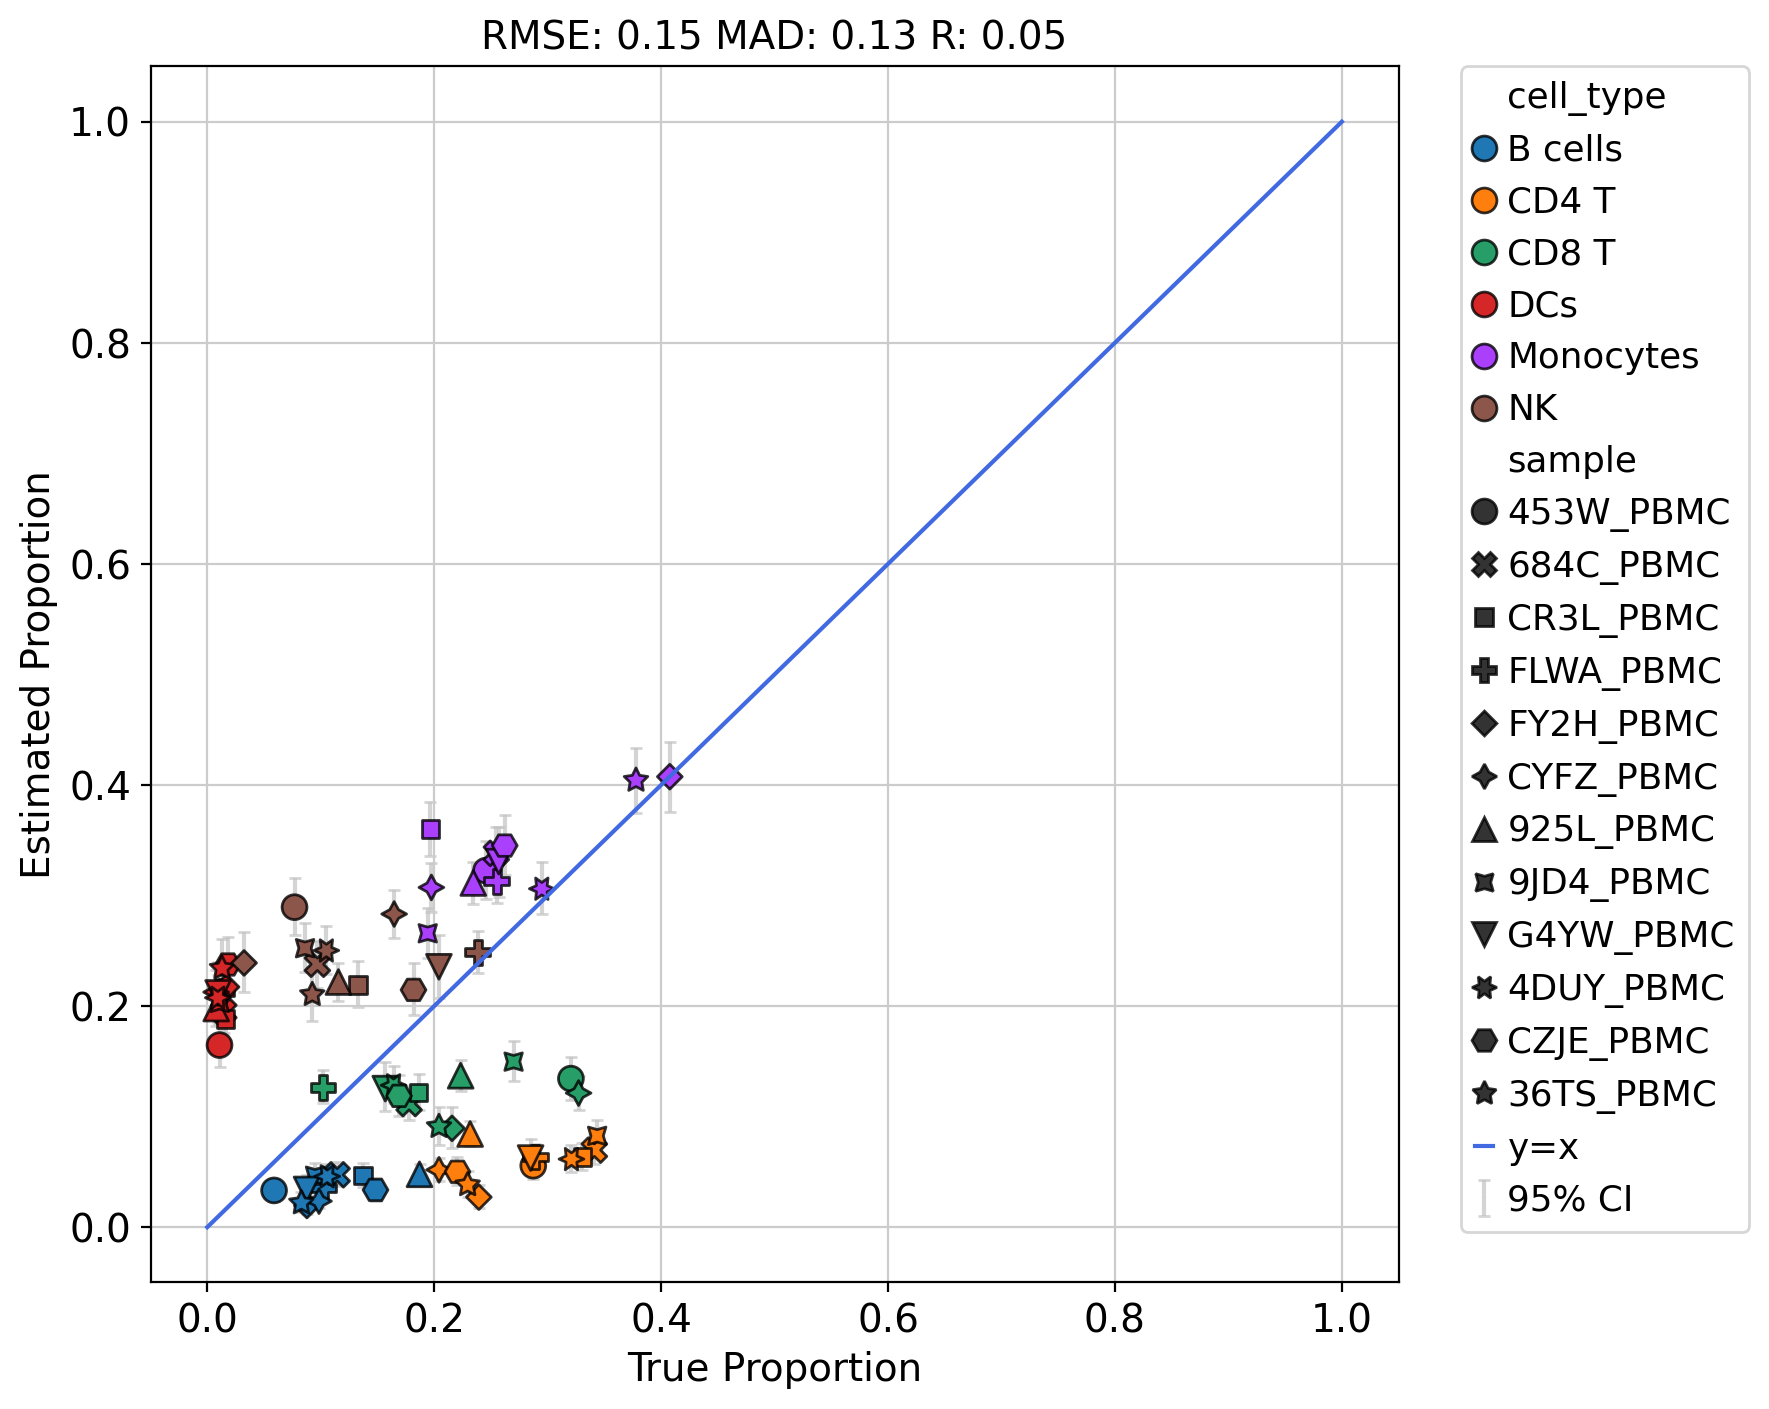

(0.1466145481063424, 0.12691093199647488, 0.054246960806977475)

In [29]:
melt = decon.get_results_df()
melt["true"] = true_df.reset_index().melt("sample")["value"].values
dv.pl.xypredictions(melt)